In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# sin 함수로 예측
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time-offsets1)*(freq1 * 10 + 10))
  series += 0.2 * np.sin((time-offsets2)*(freq2 * 30 + 30))
  series += 0.1 * (np.random.rand(batch_size, n_steps)-0.5)
  return series[..., np.newaxis].astype(np.float32)

In [4]:
# 재시작
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [5]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [6]:
# 그래프 정의
def plot_series(series, y=None, y_pred=None, x_label="$s$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [7]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, decay=0.001)

In [25]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [26]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [27]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks=tqdm_callback)

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/219           ETA: ?s - 

Epoch 1/20
219/219 [==============================] - 8s 18ms/step - loss: 0.0758 - last_time_step_mse: 0.0623 - val_loss: 0.0529 - val_last_time_step_mse: 0.0349
Epoch 2/20


0/219           ETA: ?s - 

Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0489 - last_time_step_mse: 0.0294 - val_loss: 0.0458 - val_last_time_step_mse: 0.0263
Epoch 3/20


0/219           ETA: ?s - 

Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0446 - last_time_step_mse: 0.0253 - val_loss: 0.0430 - val_last_time_step_mse: 0.0244
Epoch 4/20


0/219           ETA: ?s - 

Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0420 - last_time_step_mse: 0.0232 - val_loss: 0.0410 - val_last_time_step_mse: 0.0230
Epoch 5/20


0/219           ETA: ?s - 

Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0397 - last_time_step_mse: 0.0214 - val_loss: 0.0382 - val_last_time_step_mse: 0.0202
Epoch 6/20


0/219           ETA: ?s - 

Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0374 - last_time_step_mse: 0.0195 - val_loss: 0.0359 - val_last_time_step_mse: 0.0184
Epoch 7/20


0/219           ETA: ?s - 

Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0352 - last_time_step_mse: 0.0177 - val_loss: 0.0338 - val_last_time_step_mse: 0.0169
Epoch 8/20


0/219           ETA: ?s - 

Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0336 - last_time_step_mse: 0.0166 - val_loss: 0.0326 - val_last_time_step_mse: 0.0160
Epoch 9/20


0/219           ETA: ?s - 

Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0324 - last_time_step_mse: 0.0158 - val_loss: 0.0314 - val_last_time_step_mse: 0.0154
Epoch 10/20


0/219           ETA: ?s - 

Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0314 - last_time_step_mse: 0.0152 - val_loss: 0.0306 - val_last_time_step_mse: 0.0149
Epoch 11/20


0/219           ETA: ?s - 

Epoch 11/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0306 - last_time_step_mse: 0.0146 - val_loss: 0.0299 - val_last_time_step_mse: 0.0144
Epoch 12/20


0/219           ETA: ?s - 

Epoch 12/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0300 - last_time_step_mse: 0.0142 - val_loss: 0.0293 - val_last_time_step_mse: 0.0140
Epoch 13/20


0/219           ETA: ?s - 

Epoch 13/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0295 - last_time_step_mse: 0.0138 - val_loss: 0.0286 - val_last_time_step_mse: 0.0136
Epoch 14/20


0/219           ETA: ?s - 

Epoch 14/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0290 - last_time_step_mse: 0.0134 - val_loss: 0.0282 - val_last_time_step_mse: 0.0131
Epoch 15/20


0/219           ETA: ?s - 

Epoch 15/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0285 - last_time_step_mse: 0.0129 - val_loss: 0.0284 - val_last_time_step_mse: 0.0137
Epoch 16/20


0/219           ETA: ?s - 

Epoch 16/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0280 - last_time_step_mse: 0.0127 - val_loss: 0.0274 - val_last_time_step_mse: 0.0125
Epoch 17/20


0/219           ETA: ?s - 

Epoch 17/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0276 - last_time_step_mse: 0.0122 - val_loss: 0.0269 - val_last_time_step_mse: 0.0122
Epoch 18/20


0/219           ETA: ?s - 

Epoch 18/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0273 - last_time_step_mse: 0.0120 - val_loss: 0.0267 - val_last_time_step_mse: 0.0123
Epoch 19/20


0/219           ETA: ?s - 

Epoch 19/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0269 - last_time_step_mse: 0.0116 - val_loss: 0.0263 - val_last_time_step_mse: 0.0115
Epoch 20/20


0/219           ETA: ?s - 

Epoch 20/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0266 - last_time_step_mse: 0.0115 - val_loss: 0.0260 - val_last_time_step_mse: 0.0115


1/1 [==============================] - 1s 612ms/step


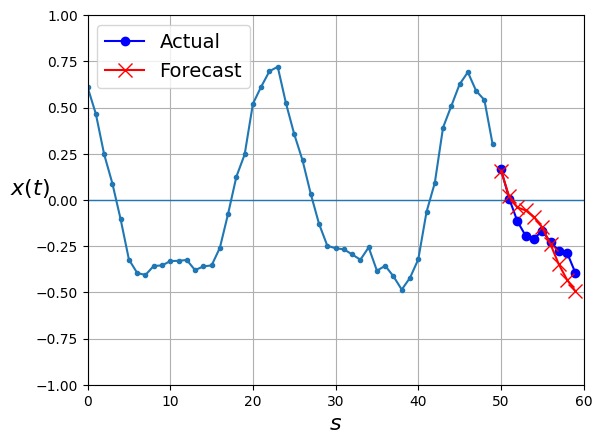

In [28]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# 그래프 정의
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
# 다중 예측 2
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

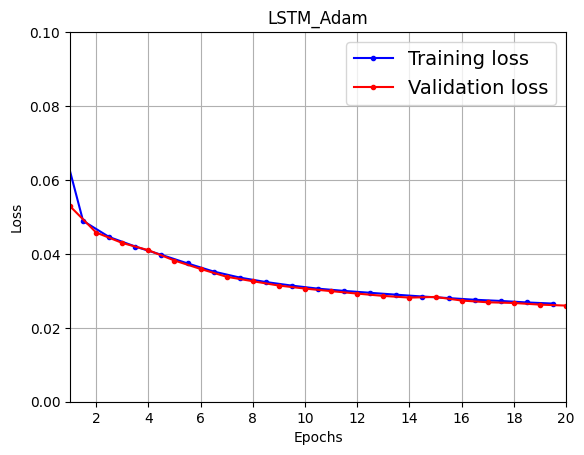

In [29]:
# loss 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.title("LSTM_Adam")
plt.show()

### GRU 모델 로드

In [30]:
# GRU
# 20 인풋 10 아웃
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [31]:
# GRU 컴파일
model.compile(loss="mse", optimizer="nadam", metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks=tqdm_callback)

1/1 [==============================] - 1s 549ms/step


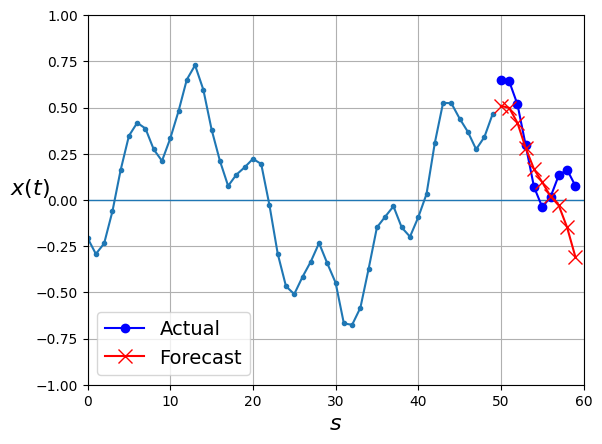

In [33]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# 그래프 정의
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
# 다중 예측 2
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

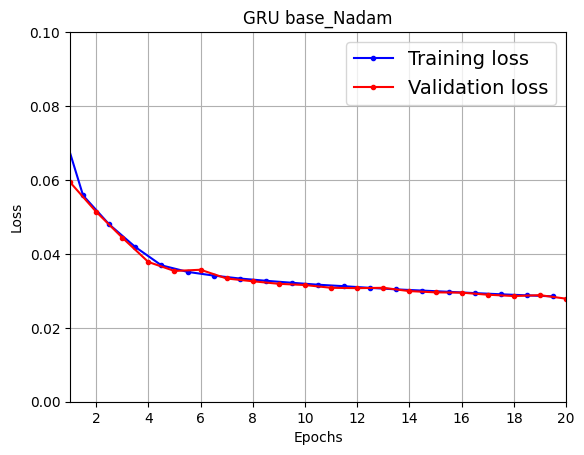

In [34]:
# loss 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.title("GRU base_Nadam")
plt.show()

#### 1d conv를 사용해 sequence 처리

In [36]:
# Conv1D 사용
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [37]:
# CNN-GRU 컴파일
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [ ]:
# 20회 학습
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks=tqdm_callback)

1/1 [==============================] - 1s 581ms/step


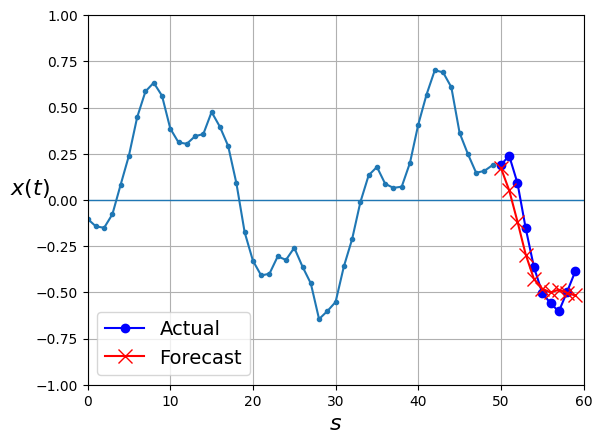

In [39]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# 그래프 정의
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
# 다중 예측 2
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

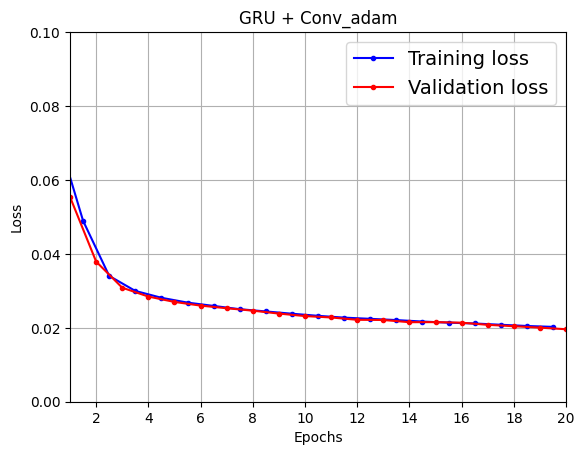

In [40]:
# loss 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.title("GRU + Conv_adam")
plt.show()

#### WaveNet 로드

- 컨볼루션 레이어를 사용해서, 상위의 레이어는 하단의 레이어를 두배로 늘린 크기로 학습함
- 긴 sequence도 처리

In [51]:
# 모델링
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [52]:
# 컴파일
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks=tqdm_callback)

1/1 [==============================] - 0s 346ms/step


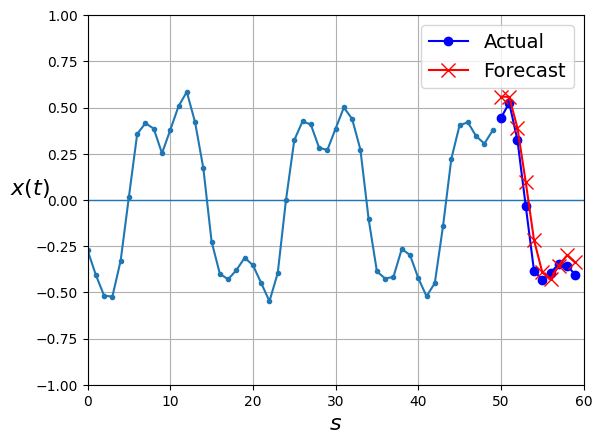

In [54]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# 그래프 정의
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
# 다중 예측 2
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

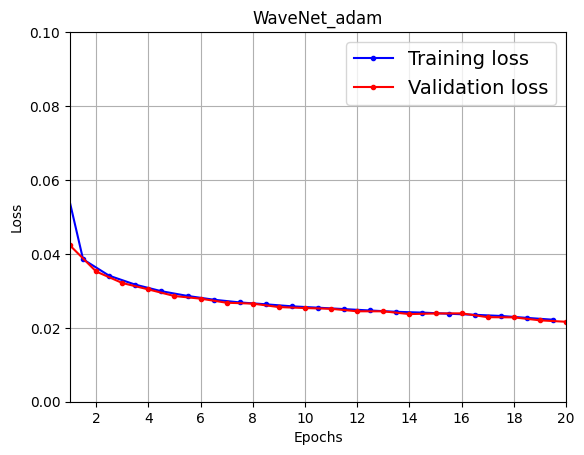

In [55]:
# loss 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.title("WaveNet_adam")
plt.show()

In [57]:
# 원본 WaveNet
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [58]:
# 입력/레이어/필터/아웃풋 재정
n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [79]:
# 동일하게 컴파일
optimizer = keras.optimizers.Nadam(learning_rate=0.002, decay=0.004)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = tqdm_callback)

1/1 [==============================] - 0s 181ms/step


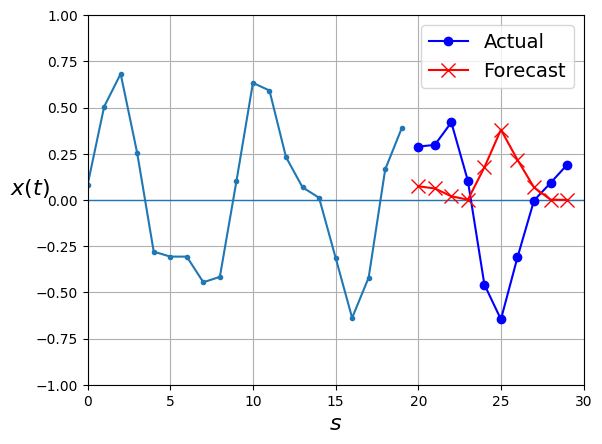

In [81]:
series = generate_time_series(1, 20 + 10)
X_new, Y_new = series[:, :20, :], series[:, 20:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# 그래프 정의
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
# 다중 예측
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

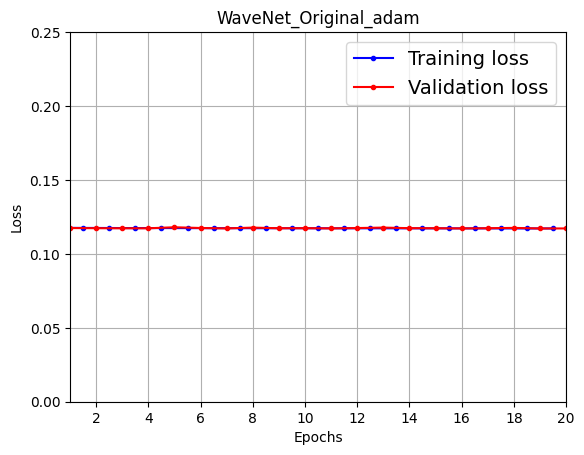

In [82]:
# loss 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.25])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.title("WaveNet_Original_adam")
plt.show()

In [83]:
# WaveNet 수정
# 모델링
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [84]:
# 컴파일
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, Y_train, epochs=30,
                    validation_data=(X_valid, Y_valid), callbacks=tqdm_callback)

1/1 [==============================] - 0s 203ms/step


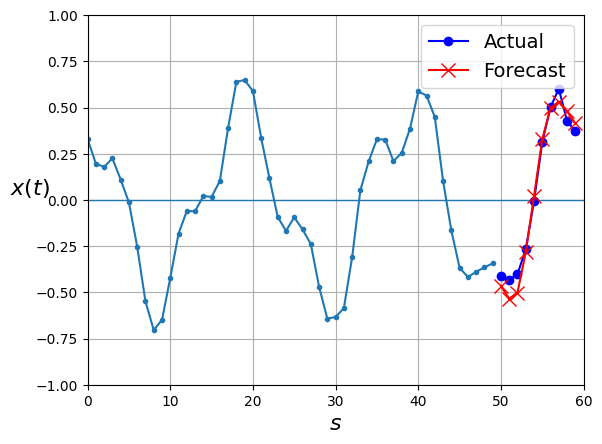

In [86]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# 그래프 정의
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
# 다중 예측 2
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

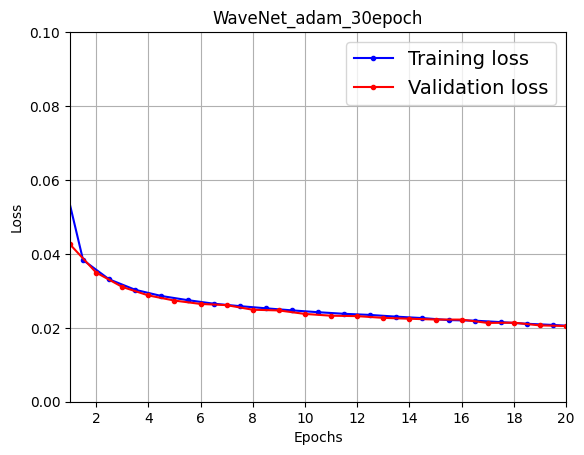

In [87]:
# loss 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.title("WaveNet_adam_30epoch")
plt.show()

In [88]:
joblib.dump(model, "WaveNet_sequence_model.h5")

['WaveNet_sequence_model.h5']